# Setup

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

tf version 2.2.0-rc3 executing eagerly is True
tfp version 0.9.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
USE_GPU = True
if USE_GPU:
    device_name = tf.test.gpu_device_name()
    print("Device name: \"{0}\"".format(device_name))
    if device_name != '/device:GPU:0':
        
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

# Data

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

CK_keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

LFW_keys_to_features = {
    'image': tf.io.FixedLenFeature([], tf.string)
}

def parserLFW(record):
    parsed = tf.io.parse_single_example(record, LFW_keys_to_features)
    
    image = tf.io.decode_raw(parsed["image"], tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=[224,224,1])
    image = tf.image.resize(image, size=[IMG_HEIGHT,IMG_WIDTH])
    image /= (255/2)
    image -= 1
    
    return {"image":image}
    
def parserCK(record):
    parsed = tf.io.parse_single_example(record, CK_keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    #return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}
    return {"image":imageExpressive}


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32
latent_dim = 100

DB_PATH = BASE_DIR


raw_LFW_train = tf.data.TFRecordDataset(DB_PATH + "trainLFW.tfrecords")
raw_LFW_test = tf.data.TFRecordDataset(DB_PATH + "testLFW.tfrecords")

raw_CK_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_CK_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

raw_novel = tf.data.TFRecordDataset(DB_PATH + "novel.tfrecords")


parsed_LFW_train = raw_LFW_train.map(parserLFW)
parsed_LFW_test = raw_LFW_test.map(parserLFW)

#raw_CK_val = raw_test.shard(2,0)
#raw_CK_test = raw_test.shard(2,1)
parsed_CK_train = raw_CK_train.map(parserCK)
#parsed_CK_val = raw_val.map(parserCK)
parsed_CK_test = raw_CK_test.map(parserCK)

parsed_train = parsed_LFW_train.concatenate(parsed_CK_train.shard(3,0)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test  = parsed_LFW_test.concatenate(  parsed_CK_test.shard(3,0)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

parsed_novel = raw_novel.map(parserCK)

# Model

In [0]:
init = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=918273645)

class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.critique = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, kernel_initializer=init),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Dense(1, activation='linear', kernel_initializer=init),     # MAY WANT TO HAVE KEPT THIS AS LINEAR ACTIVATION
        ], name="critique")
    
    @tf.function
    def __call__(self, x):
        return self.critique(x)

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim, kernel_initializer=init), # no activation...
        ], name="encode")
    
    @tf.function
    def __call__(self, x):
        mean, logvar = tf.split(self.encode(x), num_or_size_splits=2, axis=1)
        return mean, logvar


class Transformer(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Transformer, self).__init__()
        self.latent_dim = latent_dim
        self.transform = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(latent_dim, use_bias=True, kernel_initializer=init), # no activation...
        ], name="transform")

    @tf.function
    def __call__(self, z):
        return self.transform(z)

class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.decode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),

            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init,
                activation="tanh"),
        ], name="decode")

    @tf.function
    def __call__(self, z):
        return self.decode(z)


class Enhancer(tf.keras.Model):
    def __init__(self, num_filters):
        super(Enhancer, self).__init__()
        self.num_filters = num_filters
        self.grow = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(
                filters=num_filters, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),
        ], name="grow")

        self.enhance1 = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, num_filters)),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1,1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
        ], name="enhance1")
            
        self.add1 = tf.keras.layers.Add()

        self.enhance2 = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, num_filters)),
            tf.keras.layers.PReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1,1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
        ], name="enhance2")

        self.add2 = tf.keras.layers.Add()

        self.shrink = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, num_filters)),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init,
                activation="tanh"),
        ], name="shrink")

    @tf.function
    def __call__(self, x):
        x = self.grow(x)
        y = self.enhance1(x)
        x = self.add1([x, y])
        y = self.enhance2(x)
        x = self.add2([x, y])
        out = self.shrink(x)
        return out


@tf.function
def reparameterize(mean, logvar):
    # Logvar used for numerical stability
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean

@tf.function
def generateImg(enc, dec, x):
    mean, logvar = enc(x)
    return generateDist(dec, mean, logvar)

@tf.function
def generateDist(dec, mean, logvar):
    z = reparameterize(mean, logvar)
    return dec(z)


# Loss

In [0]:
prior = tfp.distributions.MultivariateNormalDiag(tf.zeros(latent_dim), tf.ones(latent_dim))
dis_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
gen_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def add_noise(x):
    noise_intensity = 1.0
    noise = tf.multiply(noise_intensity, tf.random.normal(shape=x.shape, mean=0.0, stddev=0.3))
    return tf.clip_by_value(tf.add(x, noise), -1.0, 1.0)


@tf.function
def compute_apply_gradients_critic_only(enc, dec, enh, crt, x, crtOptimizer, Wkl, Wrl, Wgl):
    with tf.GradientTape(persistent=True) as tape:
        _, _, crtLoss = compute_loss(enc, dec, enh, crt, x, Wkl, Wrl, Wgl)

    gradients_of_crt = tape.gradient(crtLoss, crt.trainable_variables)
    crtOptimizer.apply_gradients(zip(gradients_of_crt, crt.trainable_variables))

@tf.function
def compute_apply_gradients(enc, dec, enh, crt, x, encOptimizer, decOptimizer, enhOptimizer, crtOptimizer, Wkl, Wrl, Wgl):
    with tf.GradientTape(persistent=True) as tape:
        encLoss, decLoss, enhLoss, crtLoss = compute_loss(enc, dec, enh, crt, x, Wkl, Wrl, Wgl)

    gradients_of_enc = tape.gradient(encLoss, enc.trainable_variables)
    gradients_of_dec = tape.gradient(decLoss, dec.trainable_variables)
    gradients_of_enh = tape.gradient(enhLoss, enh.trainable_variables)
    gradients_of_crt = tape.gradient(crtLoss, crt.trainable_variables)

    encOptimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    decOptimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    enhOptimizer.apply_gradients(zip(gradients_of_enh, enh.trainable_variables))
    crtOptimizer.apply_gradients(zip(gradients_of_crt, crt.trainable_variables))


@tf.function
def compute_loss(enc, dec, enh, crt, x, Wkl, Wrl, Wgl):
    #Compute loss values
    klLoss, recLoss1, recLoss2, genGanLoss, crtGanLoss = compute_ALL_loss(enc, dec, enh, crt, x)

    klLoss     = tf.math.multiply(   Wkl, klLoss)
    recLoss1   = tf.math.multiply(   Wrl, recLoss1)
    recLoss2   = tf.math.multiply( 1-Wgl, recLoss2)
    genGanLoss = tf.math.multiply(   Wgl, genGanLoss)

    encLoss = tf.math.reduce_sum([
        klLoss, recLoss1#, recLoss2
    ])/2
    decLoss = tf.math.reduce_sum([  
                recLoss1#, recLoss2
    ])
    enhLoss = tf.math.reduce_sum([  
                          recLoss2, genGanLoss
    ])
    crtLoss = crtGanLoss

    return encLoss, decLoss, enhLoss, crtLoss


@tf.function
def compute_ALL_loss(enc, dec, enh, crt, x):
    mean, logvar = enc(x)

    # KL Divergence Loss
    posterior = tfp.distributions.MultivariateNormalDiag(mean, tf.exp(logvar * .5))
    divergenceLoss = tf.reduce_mean(tfp.distributions.kl_divergence(posterior, prior))

    # Reconstruction Loss for decoded image (MSE or RMSE)
    generated_images = generateDist(dec, mean, logvar)
    reconstructionLoss1 = reconstruction_loss(x, generated_images)

    # Reconstruction Loss for enhanced image
    enhanced_images = enh(generated_images)
    reconstructionLoss2 = reconstruction_loss(generated_images, enhanced_images)

    # GAN Loss
    real_scores = crt(x)    # May want to add noise?
    dec_scores = crt(generated_images)
    enh_scores = crt(enhanced_images)
    genGanLoss, crtGanLoss = compute_lsgan_loss(real_scores, dec_scores, enh_scores)
    
    return divergenceLoss, reconstructionLoss1, reconstructionLoss2, genGanLoss, crtGanLoss

@tf.function
def compute_old_gan_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)

    dis_real_loss = dis_cross_entropy(real_labels, real_output) # Try not to be fooled
    dis_fake_loss = dis_cross_entropy(fake_labels, fake_output) # Try not to be fooled
    gen_fake_loss = gen_cross_entropy(real_labels, fake_output) # Try to fool

    dis_gan_loss = tf.math.add(dis_real_loss, dis_fake_loss)
    gen_gan_loss = gen_fake_loss
    return gen_gan_loss, dis_gan_loss

@tf.function
def compute_lsgan_loss(real_output, dec_output, enh_output):
    dis_gan_loss = 0.333 * tf.reduce_sum([
        tf.reduce_mean((real_output - 1)**2),
        tf.reduce_mean(dec_output**2),
        tf.reduce_mean(enh_output**2)
    ])
    gen_gan_loss = tf.reduce_mean((enh_output - 1)**2)
    return gen_gan_loss, dis_gan_loss


@tf.function
def reconstruction_loss(actual, generated):
    return tf.reduce_mean(tf.math.square(tf.math.subtract(actual, generated)))

@tf.function
def cycle_loss(actual, generated):
    return reconstruction_loss(encoder(actual), encoder(generated))


# I/O

In [0]:
def save_StoicNet(prefix, full=False):
    if prefix is None:
        path_to_save = BASE_DIR + "saved_model"
    else:
        path_to_save = BASE_DIR + "saved_model/{}".format(prefix)
    !mkdir -p "{path_to_save}"
    print('Saving model at "{}"'.format(path_to_save))
    if full:
        encoder.save(path_to_save + "/encoder.h5")
        decoder.save(path_to_save + "/decoder.h5")
        enhancer.save(path_to_save + "/enhancer.h5")
        critic.save(path_to_save + "/critic.h5")
    else:
        encoder.save_weights(path_to_save + "/encoder.h5")
        decoder.save_weights(path_to_save + "/decoder.h5")
        enhancer.save_weights(path_to_save + "/enhancer.h5")
        critic.save_weights(path_to_save + "/critic.h5")


def load_StoicNet(prefix):
    if prefix is None:
        path_to_save = BASE_DIR + "saved_model"
    else:
        path_to_save = BASE_DIR + "saved_model/{}".format(prefix)
    
    encoder.load_weights(path_to_save + "/encoder.h5")
    decoder.load_weights(path_to_save + "/decoder.h5")
    enhancer.load_weights(path_to_save + "/enhancer.h5")
    critic.load_weights(path_to_save + "/critic.h5")

In [0]:
def save_images(epoch, test_input):
    imgs = decoder(test_input)
    assert not np.any(np.isnan(imgs))
    fig = plt.figure(figsize=(4,4))
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)


def display_novel_images():
    for image_features in parsed_novel:
        first = image_features['imageNeutral']
        second = image_features['imageExpressive']
        third = image_features['imageOther']
        test_input = np.array([first, second, third])

        images = generateImg(encoder, decoder, test_input[0:3])
        images_enhanced = enhancer(images)
        ims = np.concatenate((test_input[0:3], images, images_enhanced), axis=0)
        assert not np.any(np.isnan(ims))
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6,4))
        for i in range(ims.shape[0]):
            c = i % 3
            r = i // 3
            axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
            axes[r, c].set_yticklabels([])
            axes[r, c].xaxis.set_visible(False)
        axes[0,0].set_ylabel("Inputs", size='large')
        axes[1,0].set_ylabel("Generated", size='large')
        axes[2,0].set_ylabel("Enhanced", size='large')
        fig.tight_layout()
        #plt.savefig('novel_outputs.png')
        plt.show()


def display_imgs_ratings(test_input, epoch=-1):
    images = generateImg(encoder, decoder, test_input[0:8])
    images_enhanced = enhancer(images)
    ims = np.concatenate((test_input[0:8], images, images_enhanced), axis=0)
    assert not np.any(np.isnan(ims))
    fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(11,4))
    ratings = critic(ims)
    for i in range(ims.shape[0]):
        c = i % 8
        r = i // 8
        axes[r, c].set_title("{0:.6f}".format(ratings[i,0]))
        axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
        axes[r, c].set_yticklabels([])
        axes[r, c].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Inputs", size='large')
    axes[1,0].set_ylabel("Generated", size='large')
    axes[2,0].set_ylabel("Enhanced", size='large')
    fig.tight_layout()
    if epoch >= 0:
        plt.savefig('gens_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()


def plot_ALL_loss(ls):
    kl, rl1, rl2, gl, cl = zip(*ls)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(kl, '-g', label='kL')
    plt.plot(rl1, '-b', label='rL1')
    plt.plot(rl2, '-c', label='rL2')
    plt.plot(gl, '-y', label='gL')
    plt.plot(cl, '-r', label='cL')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


def display_feature_changes(epoch=None, base=None):
    startTime = time.time()
    print("Generating Feature Visualization", end='')
    steps = 15
    magnitude = 3.0

    # Build the feature vectors
    if base is None:
        independent_feature_vectors = np.zeros(shape=[steps*2+1, latent_dim, latent_dim])
    else:
        encoding = encoder(tf.expand_dims(base, 0))[0].numpy()
        independent_feature_vectors = np.tile(np.repeat(encoding, latent_dim, axis=0), (steps*2+1, 1, 1))
    for step in range(-1*steps, steps+1):
        step_index = step + steps
        mag = magnitude * (step/steps)
        for feature_index in range(0, latent_dim):
            independent_feature_vectors[step_index, feature_index, feature_index] = mag
    print("!", end='')

    # Make the images
    for step_index in range(0, steps*2+1):
        print(".", end='')
        encoding = independent_feature_vectors[step_index]
        imgs = enhancer(decoder(encoding))
        assert not np.any(np.isnan(imgs))
        fig = plt.figure(figsize=(10,10))
        for i in range(imgs.shape[0]):
            plt.subplot(10, 10, i+1)
            plt.imshow(imgs[i, :, :, 0], cmap='gray')
            plt.axis('off')
        fig.tight_layout()
        plt.savefig('frame_{0:03}.png'.format(step_index))
        plt.close(fig)

    # Make the animation
    if epoch is None:
        anim_filename = BASE_DIR + 'TrainingGifs/features_' + time.strftime('%l:%M_%b_%d') + '.gif'
    if type(epoch) is str:
        anim_filename = BASE_DIR + 'TrainingGifs/features_{}_'.format(epoch) + time.strftime('%l:%M_%b_%d') + '.gif'
    else:
        anim_filename = BASE_DIR + 'TrainingGifs/features_epoch_{}_'.format(epoch) + time.strftime('%l:%M_%b_%d') + '.gif'
    print("\nSaving gif at: " + anim_filename)
    with imageio.get_writer(anim_filename, mode='I') as writer:
        filenames = glob.glob('frame_*.png')
        filenames = sorted(filenames)
        filenames = filenames + filenames[::-1] # Go full circle
        for i,filename in enumerate(filenames):
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    print("Done in {} seconds".format(time.time()-startTime))


def display_image_features(image, name=None):
    if name is None:
        filename = BASE_DIR + 'TrainingGifs/image_features'
        print("Generating Image Feature Visualization", end='')
    else:
        filename = BASE_DIR + 'TrainingGifs/image_features_{}'.format(epoch)
        print("Generating Image Feature Visualization for {}".format(name), end='')
    
    fig = plt.figure()
    plt.imshow(image[:,:,0], cmap='gray')
    plt.axis('off')
    fig.tight_layout()
    plt.savefig(filename + "FULL")
    #plt.close(fig)
    
    # Build the feature vectors
    encoding = encoder(tf.expand_dims(image, 0))[0]

    independent_encodings = np.zeros(shape=[latent_dim, latent_dim])
    for feature_index in range(0, latent_dim):
        feature_value = encoding[0][feature_index]
        independent_encodings[feature_index, feature_index] = feature_value

    # Make the images
    imgs = enhancer(decoder(independent_encodings))
    assert not np.any(np.isnan(imgs))
    fig = plt.figure(figsize=(10,10))
    for i in range(imgs.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(imgs[i,:,:,0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.savefig(filename + "BREAKDOWN")
    #plt.close(fig)
    print("\t\tDone!")


# Training

In [13]:
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
#random_images_for_generation = [image_features['imageExpressive'] for image_features in parsed_CK_test.take(1)][0][0:num_examples_to_generate]
random_images_for_generation = [image_features['image'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]
print("random inputs generated")

random inputs generated


In [14]:
epochs = 150
extra_critic_training_rounds = 0

encOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
decOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
enhOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
crtOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
print("optimizers created")

encoder = Encoder(latent_dim); print("encoder built")
decoder = Decoder(latent_dim); print("decoder built")
enhancer = Enhancer(num_filters=32); print("enhancer built")
critic = Critic(); print("critic built")


optimizers created
encoder built
decoder built
enhancer built
critic built


In [0]:
FRESH = False
if not FRESH:
    #load_StoicNet("TEMP_SAVE")
    load_StoicNet("TEMP_SAVE_50")
    #load_StoicNet("TEMP_SAVE_100")
    startEpoch = 50
    print("Training loaded model from epoch {}".format(startEpoch))
else:
    print("Training a fresh model")
    startEpoch = 0

Training loaded model from epoch 50


Epoch 111, Total epoch time 293.1
Losses: k 0.11269(0.00300x37.56231)  r1 0.21691  (r2 0.00099 g 0.029188)(0.03000)  c 0.00152


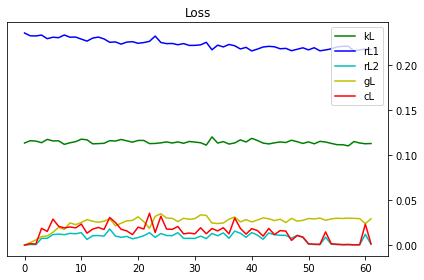

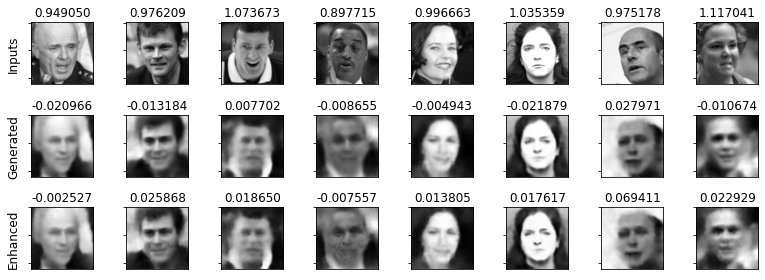


Training All

KeyboardInterrupt: ignored

In [0]:
# Wkl (aka beta) weighs KL Divergence loss, limiting encoding capacity 
Wkl = tf.convert_to_tensor(0.003, dtype=tf.float32)
max_Wkl = 0.003
Wkl_ramp_start = -1   # Ramps up
Wkl_ramp_end = 10


# Wrl weighs reconstruction loss 1
Wrl = tf.convert_to_tensor(5.0, dtype=tf.float32)
max_Wrl = 5.0
Wrl_ramp_start = 1   # Ramps up
Wrl_ramp_end = 15

# Wgl weighs gan loss vs reconstruction loss 2 for generator
Wgl = tf.convert_to_tensor(0.03, dtype=tf.float32)
max_Wgl = 0.03
Wgl_ramp_start = 50   # Ramps up
Wgl_ramp_end = 60

# Enhancer not doing much with 0.015 with rl2 based on dec(enc(x)) instead of x
# 0.03 was better!

ls = []
bestLoss = 999999.9
start_time = time.time()
for epoch in range(startEpoch, epochs):
    # Train
    Wkl = min(max_Wkl, max_Wkl * (max(0, (epoch - Wkl_ramp_start)) / (Wkl_ramp_end - Wkl_ramp_start)))
    Wkl = tf.convert_to_tensor(Wkl, dtype=tf.float32)

    Wgl = min(max_Wgl, max_Wgl * (max(0, (epoch - Wgl_ramp_start)) / (Wgl_ramp_end - Wgl_ramp_start)))
    Wgl = tf.convert_to_tensor(Wgl, dtype=tf.float32)

    for training_round in range(0, extra_critic_training_rounds):
        print("\nTraining Critic Round {}".format(training_round), end="")
        batchCounter = 0
        for image_features in parsed_train:
            image_raw = image_features['image']

            compute_apply_gradients_critic_only(
                encoder, decoder, enhancer, critic,
                image_raw, crtOptimizer,
                Wkl, Wrl, Wgl)

            batchCounter += 1
            if batchCounter % 10 == 0:
                print(".", end="")
    
    print("\nTraining All", end="")
    batchCounter = 0
    for image_features in parsed_train:
        image_raw = image_features['image']

        compute_apply_gradients(
            encoder, decoder, enhancer, critic,
            image_raw,
            encOptimizer, decOptimizer, enhOptimizer, crtOptimizer,
            Wkl, Wrl, Wgl)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    
    # Test
    print("\nTesting All", end="")
    batchCounter = 0
    kloss = tf.keras.metrics.Mean()
    rloss1 = tf.keras.metrics.Mean()
    rloss2 = tf.keras.metrics.Mean()
    gloss = tf.keras.metrics.Mean()
    closs = tf.keras.metrics.Mean()
    for image_features in parsed_test:
        image_raw = image_features['image']

        kl, rl1, rl2, gl, cl = compute_ALL_loss(
            encoder, decoder, enhancer, critic,
            image_raw)
        
        kloss(kl)
        rloss1(rl1)
        rloss2(rl2)
        gloss(gl)
        closs(cl)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")

    kl_base = kloss.result().numpy()
    kl = tf.math.multiply(kloss.result(), Wkl).numpy()
    rl1 = tf.math.multiply(rloss1.result(), Wrl).numpy()
    rl2 = tf.math.multiply(rloss2.result(), 1-Wgl).numpy()
    gl = tf.math.multiply(gloss.result(), Wgl).numpy()
    cl = closs.result().numpy()
    ls = ls + [(kl, rl1, rl2, gl, cl)]
    
    end_time = time.time()

    # Output
    display.clear_output(wait=False)
    print('Epoch {0}, Total epoch time {1:.1f}'.format(epoch, end_time-start_time))
    print('Losses: k {0:.5f}({1:.5f}x{2:.5f})  r1 {3:.5f}  (r2 {4:.5f} g {5:.6f})({6:.5f})  c {7:.5f}'.format(
            kl, Wkl, kl_base, rl1, rl2, gl, Wgl, cl))
    plot_ALL_loss(ls)
    display_imgs_ratings(random_images_for_generation)
    #save_images(epoch, random_vector_for_generation)
    #display_novel_images()

    # Save the model from time to time or if you get a new record (after sufficient training)
    if epoch > 20 and kl + rl2 + gl < bestLoss:
        bestLoss = kl + rl2 + gl
        save_StoicNet("TEMP_BEST_MODEL")
        print("*Saved new best*")
    if (epoch + 1) % 25 == 0:
        display_feature_changes(epoch+1)
        save_StoicNet("TEMP_SAVE")
    elif (epoch + 1) % 5 == 0:
        save_StoicNet("TEMP_SAVE")

    tf.keras.backend.clear_session()
    start_time = time.time()

# Save & Test

In [0]:
saveName = "FINAL_SAVE_"+time.strftime('%l_%M_%b%d')

In [0]:
save_StoicNet(saveName)

Saving model at "/content/drive/My Drive/StoicNetData/saved_model/FINAL_SAVE_ 3_15_Apr18"


In [0]:
display_feature_changes(epoch="FINAL")
display_feature_changes(epoch="good guy test", base=random_images_for_generation[1])

Generating Feature Visualization!...............................
Saving gif at: /content/drive/My Drive/StoicNetData/TrainingGifs/features_FINAL_ 3:16_Apr_18.gif
Done in 78.20420813560486 seconds
Generating Feature VisualizationWARNING:tensorflow:5 out of the last 6 calls to <function Encoder.__call__ at 0x7f7380935f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
!...............................
Saving gif at: /content/drive/My Drive/StoicNetData/TrainingGifs/features_good guy test_ 3:18_Apr_18.gif
Done in 76.27823615074158 seconds


In [0]:
load_StoicNet("FINAL_SAVE_Best")

In [19]:
display_feature_changes(epoch="good guy test", base=random_images_for_generation[5])

Generating Feature Visualization!...............................
Saving gif at: /content/drive/My Drive/StoicNetData/TrainingGifs/features_good guy test_ 3:16_Apr_18.gif
Done in 92.78115200996399 seconds
